In [0]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import math
import random
from scipy.linalg import eig

plt.rcParams["figure.figsize"] = (10,6)

## Simulating an Ising model using Gibbs sampling:

In [0]:
# Computes adjacency matrix for an n x n lattice
# with periodic boundary conditions:
def f_2D_Grid_Adjacency(n):
    E = np.zeros((n**2,n**2))
    v = np.arange(n**2)

    for i in v:
        # If we're not at the last element in a row,
        # create an edge to the vertex on our right:
        if np.mod(i+1,n) != 0:
            E[i,i+1] = 1
        # If we're at the last element in a row, create
        # an edge to the first element in the row:
        else:
            E[i,i+1-n] = 1
        # If we're not at the first element in a row,
        # create an edge to the vertex on our left:
        if np.mod(i,n) != 0:
            E[i,i-1] = 1
        # If we're at the first element in a row, create
        # an edge to the last element in the row:
        else:
            E[i,i-1+n] = 1
        # If we're not at the last element in a column, create
        # an edge to the next vertex down:
        if i+n in v:
            E[i,i+n] = 1
        # If we're at the last element in a column, create
        # an edge to the first vertex in the column:
        else:
            E[i,i+n-n**2] = 1
        # If we're not at the first element in a column, create
        # an edge to the next vertex up:
        if i-n in v:
            E[i,i-n] = 1
        # If we're at the first element in a column, create
        # an edge to the last vertex in the column:
        else:
            E[i,i-n+n**2] = 1
            
    return E

<function matplotlib.pyplot.show>

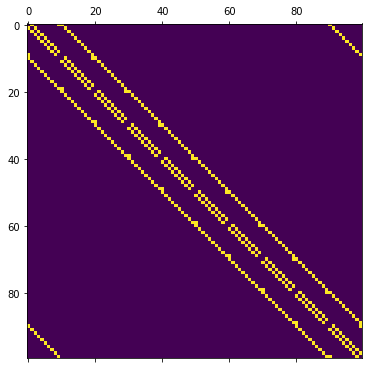

In [209]:
# Plot the adjacency matrix:
E = f_2D_Grid_Adjacency(n=10)
plt.matshow(E)
plt.show

# print("rank=",np.linalg.matrix_rank(E))
# E_inv = np.linalg.inv(E)
# plt.matshow(E_inv)
# plt.show

In [0]:
# Computes the argument of the Ising Hamiltonian function:
def f_Hamiltonian_arg(E,x):
    # Inputs: adjacency matrix E and state vector x
    
    # Loop over all neighboring states.
    Sum = 0
    indices = np.argwhere(E == 1)
    for i,j in indices:
        if i > j:
            Sum += x[i]*x[j]
    return Sum

In [0]:
# Computes a state transition by Gibbs sampling:
def f_State_Transition(E,beta,state):
    # Create a proposal distribution in which one element has a flipped spin
    proposal = np.empty_like(state)
    proposal[:] = state
    i = np.random.choice(np.shape(state)[0]) # Pick a random state
    proposal[i] = -proposal[i] # Flip the spin of the state
    # Compute the ratio of the Hamiltonians:
    ratio = np.exp(beta*(f_Hamiltonian_arg(E,proposal) - f_Hamiltonian_arg(E,state)))
    alpha = np.minimum(1,ratio) # Acceptance probability
    # Accept the proposal with probability alpha:
    indicator = np.random.choice(a = np.array([1,0]),p=[alpha,1-alpha])
    if indicator == 1:
        state = proposal
    return state

In [0]:
# Simulate the Ising model on a graph with adjacency matrix E
# using Gibbs sampling, with parameter 'beta' and 'it' iterations
def f_Gibbs_Ising(it,beta,E):
    n = np.shape(E)[0]
    # Start from a uniform random distibution:
    state = np.random.choice(a = np.array([1,-1]),size=n)
    for i in np.arange(it):
        state = f_State_Transition(E,beta,state)
    return state

In [0]:
# Plot image using adjacency matrix
def f_Plot_Lattice(state):
  n = np.shape(state)[0]
  grid_length = int(np.sqrt(n))
  Grid = np.reshape(state,(grid_length,grid_length))
  fig = plt.figure()
  plt.matshow(Grid)
  plt.show

<Figure size 720x432 with 0 Axes>

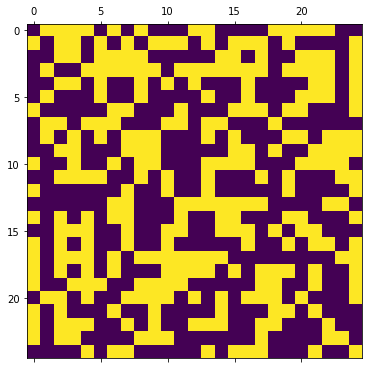

In [0]:
# Simulate white noise:
grid_length = 25
n = grid_length**2 # Vertices
state1 = np.random.choice(a = np.array([1,-1]),size=n)

f_Plot_Lattice(state1)

<Figure size 720x432 with 0 Axes>

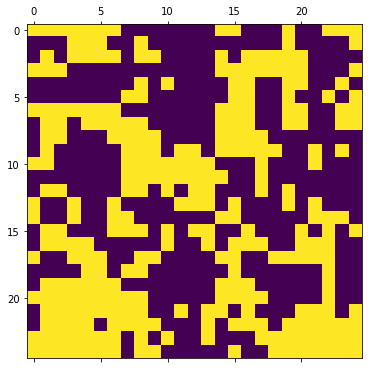

In [0]:
# Test the Gibbs sampler:
# beta is the "inverse temperature" parameter.

grid_length = 25
it = 1000
beta = 0.3

E = f_2D_Grid_Adjacency(grid_length)
state2 = f_Gibbs_Ising(it,beta,E)

f_Plot_Lattice(state2)

In [0]:
# # Multiply the generated image with the circulant matrix:

# state = state2
# n = np.shape(state)[0]
# grid_length = int(np.sqrt(n))

# conv = np.matmul(E,state)
# np.shape(conv)
# f_Plot_Lattice(conv)

<Figure size 720x432 with 0 Axes>

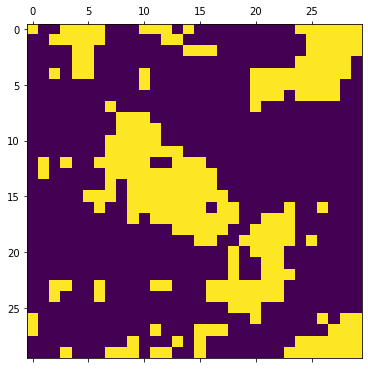

In [0]:
# Test the Gibbs sampler:

grid_length = 30
it = 10000
beta = 0.5

E = f_2D_Grid_Adjacency(grid_length)
state3 = f_Gibbs_Ising(it,beta,E)

f_Plot_Lattice(state3)

# beta is the "inverse temperature" parameter.
# As beta is increased, the "temperature" decreases,
# and we more commonly see larger blocks in the same state.

<Figure size 720x432 with 0 Axes>

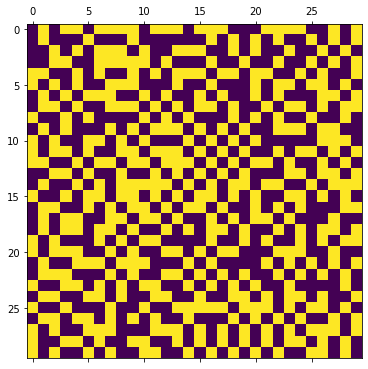

In [193]:
# Test the Gibbs sampler:
# Using beta with negative sign and sufficiently large modulus,
# we get a checkboard pattern. This corresponds to a high-energy state.

grid_length = 30
it = 1000
beta = -1

E = f_2D_Grid_Adjacency(grid_length)
state4 = f_Gibbs_Ising(it,beta,E)

f_Plot_Lattice(state4)

### Learning the statistics of data generated on graphs.

### The Toeplitz matrix representation of convolution is like an adjacency matrix. The adjacency matrix of a lattice is a circulant matrix, which is a kind of Toeplitz matrix. This inspired the following idea: learning a convolution matrix is like learning the adjacency matrix which describes the generative model of the training data.

### This can be done simply by strenghening the weight between pixels / vertices whenever the pixels are in the same state. (Here we're thinking of there only being two possible states.) This can be generalized to a continuum of intensities by instead requiring that the two pixels have nearly the same intensity.

### In other words, we are just averaging the autocorrelation of individual pixels over many iterations in order to recover the underlying graph structure of the generative model.

In [0]:
# Loop through all pairs of vertices. If the vertices are in the same state,
# increase the weight of the edge between them in the adjacency matrix.

def f_A(A,E,state):
  for i in np.arange(np.shape(state)[0]):
      for j in np.arange(np.shape(state)[0]):
          if state[i] == state[j] and i > j:
              A[i,j] += 1
  return A

In [0]:
# Same function, but in addition, require that the pixel be in the "up" state.

def f_A2(A,E,state):
  for i in np.arange(np.shape(state)[0]):
      for j in np.arange(np.shape(state)[0]):
          if state[i] == state[j] and i > j and state[i] == 1:
              A[i,j] += 1
  return A

### Here's what this looks like after a single training image / weight update:

### For white noise:

<function matplotlib.pyplot.show>

<Figure size 432x288 with 0 Axes>

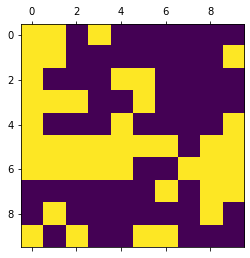

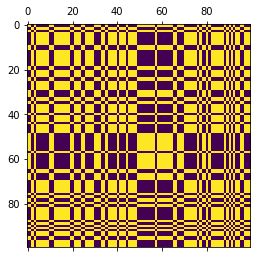

In [0]:
# Simulate white noise:
grid_length = 10
E = f_2D_Grid_Adjacency(grid_length)
state = np.random.choice(a = np.array([1,-1]),size=grid_length**2)

f_Plot_Lattice(state)

A = np.zeros((np.shape(E)))
A = f_A2(A,E,state)
plt.matshow(A)
plt.show

### For data generated by an Ising model:

<function matplotlib.pyplot.show>

<Figure size 432x288 with 0 Axes>

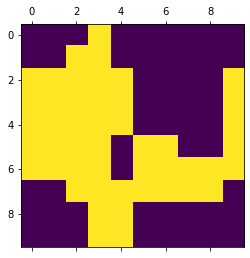

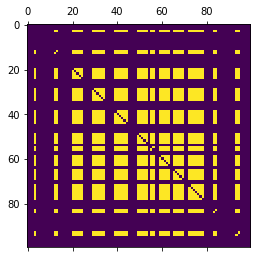

In [0]:
grid_length = 10
it = 2*grid_length**2
beta = 0.5

E = f_2D_Grid_Adjacency(grid_length)

state = f_Gibbs_Ising(it,beta,E)

f_Plot_Lattice(state)

A = np.ones((np.shape(E)))
A = f_A2(A,E,state)
A = A + np.transpose(A)
plt.matshow(A)
plt.show

### Now we average over many iterations:

<function matplotlib.pyplot.show>

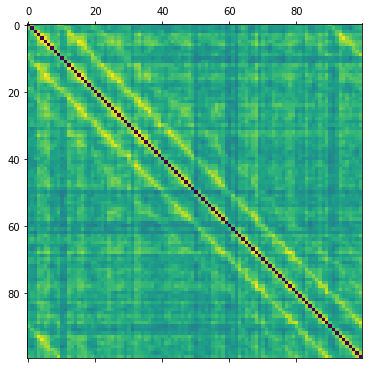

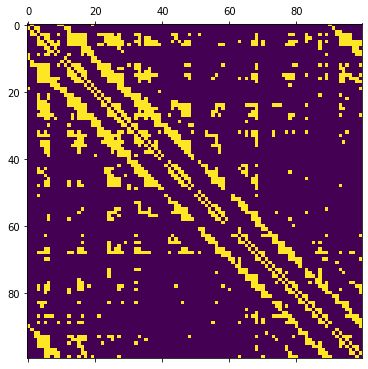

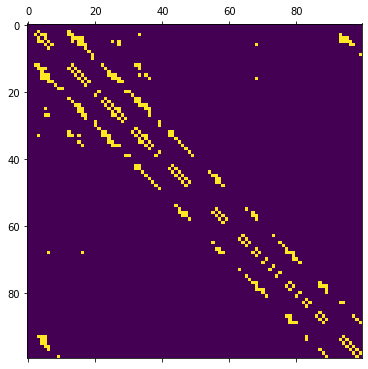

In [210]:
grid_length = 10
it = 2*grid_length**2
beta = 0.5

E = f_2D_Grid_Adjacency(grid_length)
A = np.zeros((np.shape(E)))

itz = 200
for i in np.arange(itz):
  state = f_Gibbs_Ising(it,beta,E)
  A = f_A2(A,E,state)
A /= itz
A = A + np.transpose(A)

plt.matshow(A)
plt.show

S = A > 0.3
plt.matshow(S)
plt.show

S = A > 0.35
plt.matshow(S)
plt.show

### We've recovered an approximation of the lattice adjacency matrix on which the data was generated.

### Performing the same process on noise just outputs noise.

<function matplotlib.pyplot.show>

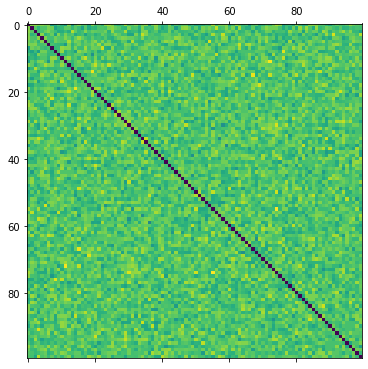

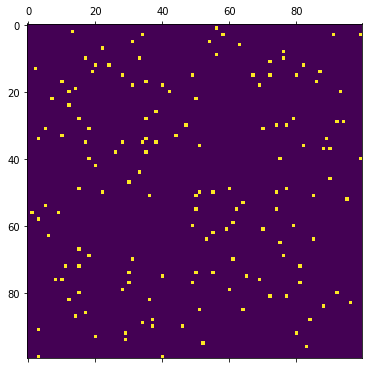

In [0]:
grid_length = 10
it = 2*grid_length**2
beta = 0.5

E = f_2D_Grid_Adjacency(grid_length)
A = np.zeros((np.shape(E)))

itz = 100
for i in np.arange(itz):
  state = np.random.choice(a = np.array([1,-1]),size=grid_length**2)
  A = f_A(A,E,state)
A /= itz
A = A + np.transpose(A)

plt.matshow(A)
plt.show

S = A > 0.6
plt.matshow(S)
plt.show

### Now, let's try this on MNIST Data:

In [14]:
# Load the data:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


(5421,)


<function matplotlib.pyplot.show>

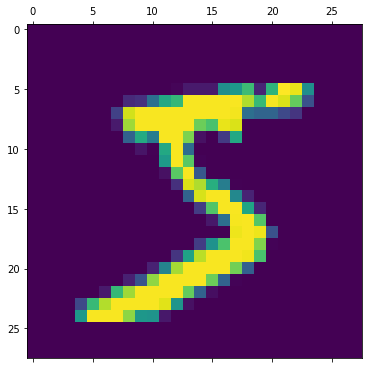

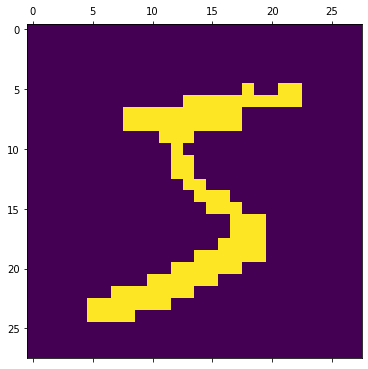

In [15]:
# Get the indices of all 5s:
idx5 = np.where(Y_train == 5)[0]
print(np.shape(idx5))

# Plot:
M = X_train[idx5[0]]
plt.matshow(M)
plt.show

# Plot a 2-state version:
S = M > 2*np.max(M)/3 # Clip all pixels with intensity less than 2/3 the maximum
plt.matshow(S)
plt.show

In [0]:
# Average the adjacency matrices:
grid_length = 10
E = f_2D_Grid_Adjacency(grid_length)
A = np.zeros((28**2,28**2))

itz = 200
for i in np.arange(itz):
  M = X_train[idx5[i]]
  # Clip all pixels with intensity less than 2/3 the max:
  state = np.reshape(M > 2*np.max(M)/3,(28**2,1))
  A = f_A2(A,E,state)
A /= itz
A = A + np.transpose(A)

Total edges in graph = 614656
Total edges in adjacency matrix = 134614
Total edges in sparse adjacency matrix 1= 12744
Total edges in sparse adjacency matrix 2 = 2114


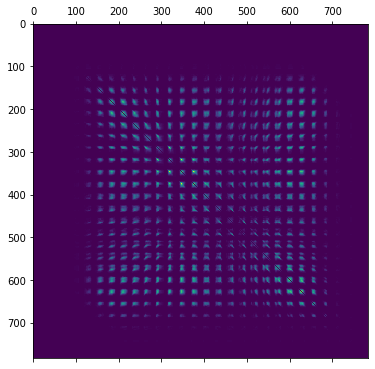

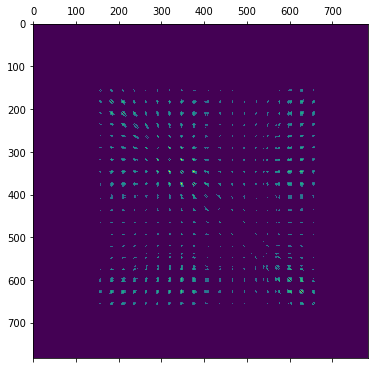

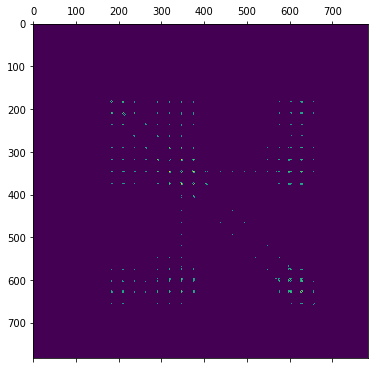

In [206]:
# Plot the weighted matrix returned by this process,
# and adjacency matrices produced by clipping low values.

Edges_Total = np.shape(A)[0]**2

plt.matshow(A)
Edges_A = np.sum(A>0)
plt.show

S1 = A*(A > 0.3*np.max(A))
Edges_S1 = np.sum(S1>0)
plt.matshow(S1)
plt.show

S2 = A*(A > 0.5*np.max(A))
Edges_S2 = np.sum(S2>0)
plt.matshow(S2)
plt.show

adj = S2 > 0

print("Total edges in graph =", Edges_Total)
print("Total edges in adjacency matrix =", Edges_A)
print("Total edges in sparse adjacency matrix 1=", Edges_S1)
print("Total edges in sparse adjacency matrix 2 =", Edges_S2)

### To test that we've learned the right graph structure, we can simulate the Ising model on this adjacency matrix.

<Figure size 720x432 with 0 Axes>

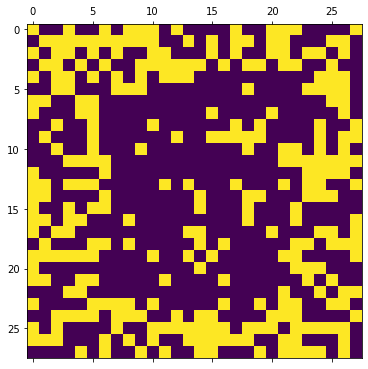

In [0]:
it = 1000
beta = 2
state = f_Gibbs_Ising(it,beta,adj)

f_Plot_Lattice(state)

### Here's a better idea: We can find the stationary distribution of the corresponding Markov chain. This is the limiting distribution of random walks on the graph.

### First, we'll need some more functions:

In [0]:
# Convert an adjacency matrix to a stochastic matrix:
# Add a small, nonzero probability of transitioning
# to a vertex that is not connected by an edge
def f_Stochastic_Mat(G,p=0.95):
    n = np.shape(G)[0]
    r = G.sum(axis=1)
    M = np.zeros((n,n))
    for i in np.arange(n):
        for j in np.arange(n):
            if r[i] != 0:
                M[i,j] = p*G[i,j]/max(1,r[i]) + (1-p)/n
            else:
                M[i,j] = 1/n
    return M

# This function computes the stationary distribution
# of a matrix K.
def f_Stationary(K):
  import warnings
  warnings.filterwarnings("ignore")
  n = K.shape[0]
  A = (np.eye(n) - K).T
  a = np.vstack((A, np.ones(n)))
  b = np.matrix([0]*n + [1]).T
  pi = np.squeeze(np.asarray(np.linalg.lstsq(a,b)[0].T))
  return pi

# Computes page rank of vertices in adjacency matrix G
def f_Page_Rank(G):
    M = f_Stochastic_Mat(G)
    v = f_Stationary(M)
    page_rank = np.abs(v).argsort()[::-1]
    v_sort = v[page_rank]
    return page_rank, v, v_sort

Connectivity = 21.9 %


<Figure size 720x432 with 0 Axes>

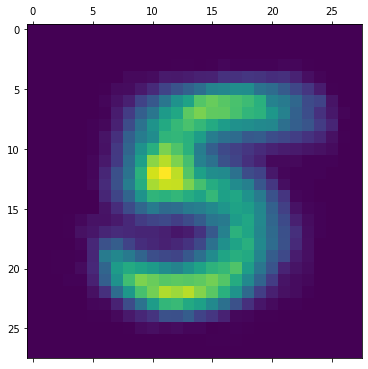

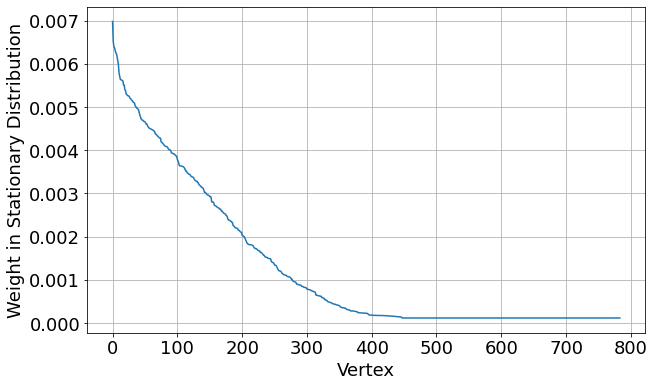

In [207]:
# Plot stationary distribution:

page_rank, v, v_sort = f_Page_Rank(A)

f_Plot_Lattice(v)

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

# Plot the sorted time spent at each vertex:
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(v_sort)
plt.xlabel('Vertex', fontsize=18)
plt.ylabel('Weight in Stationary Distribution', fontsize=18)
plt.grid()

# Print the percent of edges with nonzero weights:
print("Connectivity =", np.round(100*Edges_A/Edges_Total,2), "%")

### Just taking an average of all the images (rather than an average of the adjacency matrices) produces a less typical-looking result:

<function matplotlib.pyplot.show>

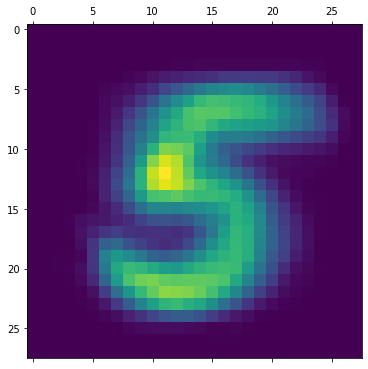

In [213]:
grid_length = 10

E = f_2D_Grid_Adjacency(grid_length)
M_avg = np.zeros((28,28))

itz = 200
for i in np.arange(itz):
    M_avg += X_train[idx5[i]]
    
plt.matshow(M_avg)
plt.show

### We now try some additional variations on this idea. Rather than simply incrementing the edge between vertices if their states are the same, let's add an edge weight equal to the state. We can generalize the technique to a continuum of pixel values by only incrementing an edge between pixel intensities are sufficiently close.

In [0]:
# Now we add the average intensity of two pixels to the edge between them,
# if their difference falls within some margin and the pixel intensity
# is sufficiently high.
def f_A3(A,E,state):
  maximum = np.max(state)
  margin = 3
  for i in np.arange(np.shape(state)[0]):
      for j in np.arange(np.shape(state)[0]):
          if np.abs(state[i] - state[j]) < margin and i > j:
              A[i,j] += state[i]
  return A

In [0]:
grid_length = 10
it = 2*grid_length**2
beta = 0.5

E = f_2D_Grid_Adjacency(grid_length)
A = np.zeros((grid_length**2,grid_length**2))

itz = 200
for i in np.arange(itz):
  state = f_Gibbs_Ising(it,beta,E)
  A = f_A4(A,E,state)
A /= itz
A = A + np.transpose(A)

<function matplotlib.pyplot.show>

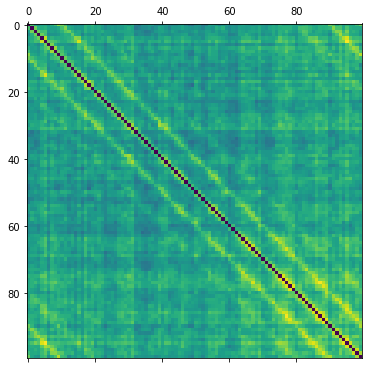

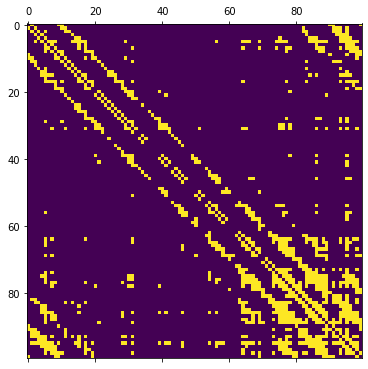

In [111]:
plt.matshow(A)
plt.show

S2 = A > 0.7*np.max(A)
plt.matshow(S2)
plt.show

In [0]:
grid_length = 10
E = f_2D_Grid_Adjacency(grid_length)
A = np.zeros((28**2,28**2))

itz = 200
for i in np.arange(itz):
  M = X_train[idx5[i]]
  state = np.reshape(M,(28**2,1))
  A = f_A3(A,E,state)
A /= itz
A = A + np.transpose(A)

Total Edges =  614656
184448
29158
2846


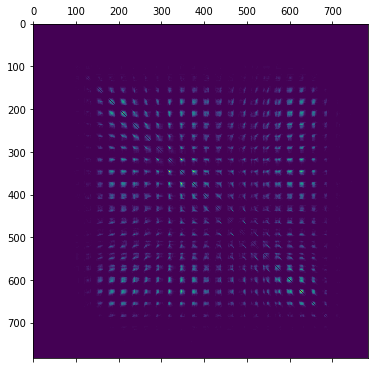

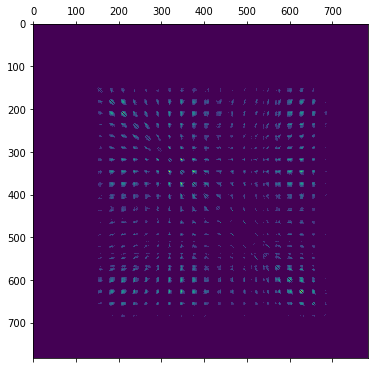

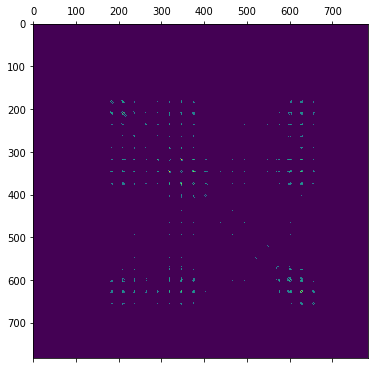

In [172]:
Edges_Total = np.shape(A)[0]**2

plt.matshow(A)
Edges_A = np.sum(A>0)
plt.show

S1 = A * (A > 0.1*np.max(A))
Edges_S1 = np.sum(S1>0)
plt.matshow(S1)
plt.show

S2 = A * (A > 0.35*np.max(A))
Edges_S2 = np.sum(S2>0)
plt.matshow(S2)
plt.show

print("Total edges in graph =", Edges_Total)
print("Total edges in adjacency matrix =", Edges_A)
print("Total edges in sparse adjacency matrix 1=", Edges_S1)
print("Total edges in sparse adjacency matrix 2 =", Edges_S2)

Connectivity = 30.01 %


<Figure size 720x432 with 0 Axes>

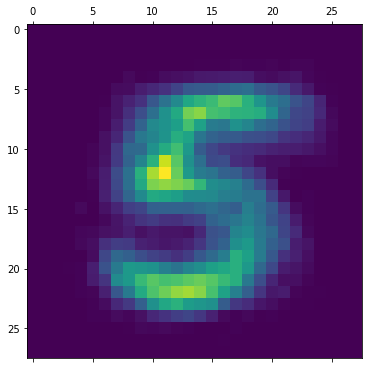

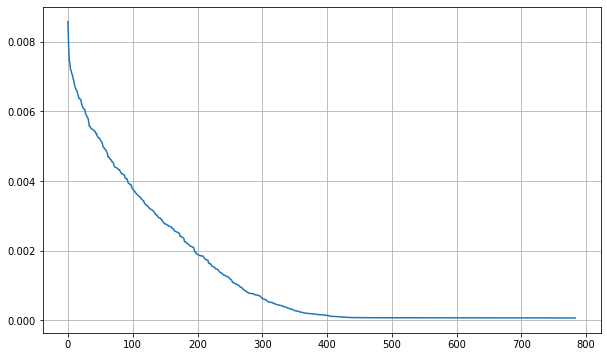

In [165]:
# Plot using the sparser adjacency matrix:

page_rank, v, v_sort = f_Page_Rank(A)

f_Plot_Lattice(v)

print("Connectivity =", np.round(100*Edges_A/Edges_Total,2), "%")
# Plot the sorted time spent at each vertex:
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(v_sort)
plt.xlabel('Vertex', fontsize=18)
plt.ylabel('Weight in Stationary Distribution', fontsize=16)
plt.grid()

Connectivity = 4.74 %


<Figure size 720x432 with 0 Axes>

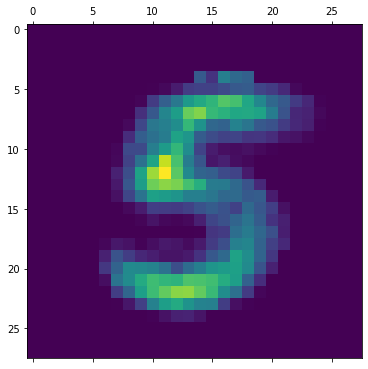

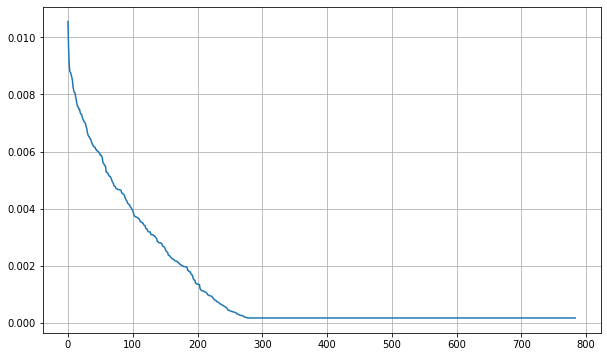

In [166]:
# Plot using the sparser adjacency matrix:

page_rank, v, v_sort = f_Page_Rank(S1)

f_Plot_Lattice(v)

print("Connectivity =", np.round(100*Edges_S1/Edges_Total,2), "%")
# Plot the sorted time spent at each vertex:
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(v_sort)
plt.xlabel('Vertex', fontsize=18)
plt.ylabel('Weight in Stationary Distribution', fontsize=16)
plt.grid()

Connectivity = 0.46 %


<Figure size 720x432 with 0 Axes>

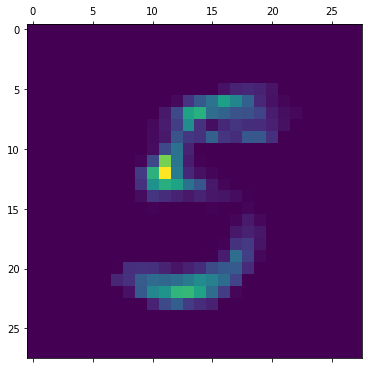

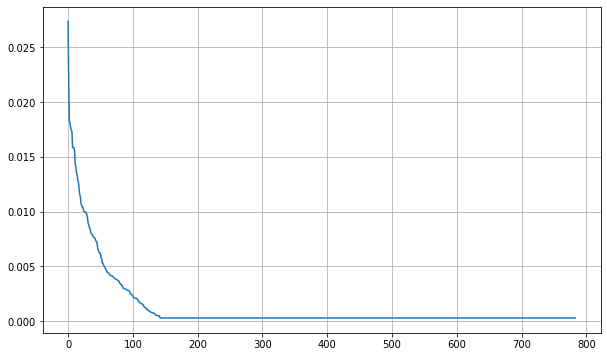

In [173]:
# Plot using the sparser adjacency matrix:

page_rank, v, v_sort = f_Page_Rank(S2)

f_Plot_Lattice(v)

print("Connectivity =", np.round(100*Edges_S2/Edges_Total,2), "%")
# Plot the sorted time spent at each vertex:
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(v_sort)
plt.xlabel('Vertex', fontsize=18)
plt.ylabel('Weight in Stationary Distribution', fontsize=16)
plt.grid()